In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [12]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [13]:
FEATURES = 28

In [14]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [19]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [20]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[[ 0.8692932  -0.6350818   0.22569026 ...  0.72165745  0.98875093
   0.87667835]
 [ 0.9075421   0.32914728  0.35941187 ...  0.77973217  0.99235576
   0.7983426 ]
 [ 0.79883474  1.4706388  -1.6359748  ...  0.8032515   0.8659244
   0.7801176 ]
 ...
 [ 0.4814969  -0.44418392 -1.6454076  ...  0.64619136  0.6939376
   0.6955113 ]
 [ 0.56476605  0.26291743  0.5430709  ...  0.7223196   0.93818957
   0.8478069 ]
 [ 0.44105193  0.80152214 -0.33426744 ...  0.6051652   0.9711247
   0.89249057]], shape=(1000, 28), dtype=float32)


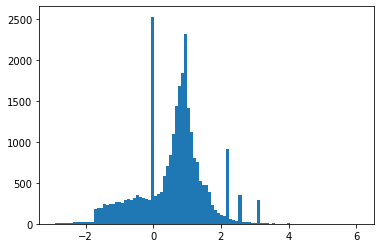

In [22]:
for features,label in packed_ds.batch(1000).take(1):
  print(features)
  plt.hist(features.numpy().flatten(), bins = 101)

In [24]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [25]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [26]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [27]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

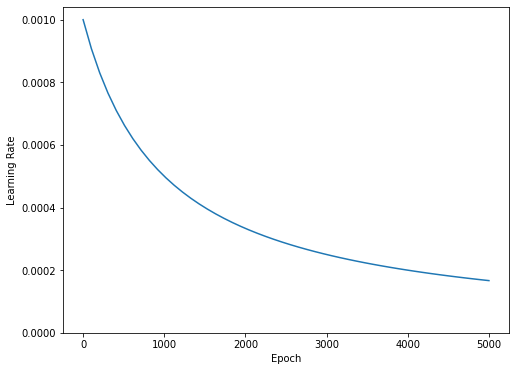

In [28]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [29]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [30]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [31]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [32]:
size_histories = {}

In [33]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4725,  binary_crossentropy:0.7991,  loss:0.7991,  val_accuracy:0.4600,  val_binary_crossentropy:0.7762,  val_loss:0.7762,  
....................................................................................................
Epoch: 100, accuracy:0.5932,  binary_crossentropy:0.6300,  loss:0.6300,  val_accuracy:0.5640,  val_binary_crossentropy:0.6321,  val_loss:0.6321,  
....................................................................................................
Epoch: 200, accuracy:0.60

(0.5, 0.7)

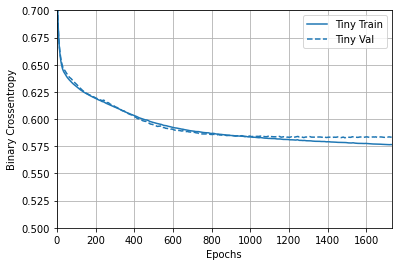

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [35]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [36]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4875,  binary_crossentropy:0.7775,  loss:0.7775,  val_accuracy:0.5080,  val_binary_crossentropy:0.7256,  val_loss:0.7256,  
....................................................................................................
Epoch: 100, accuracy:0.6130,  binary_crossentropy:0.6184,  loss:0.6184,  val_accuracy:0.6000,  val_binary_crossentropy:0.6139,  val_loss:0.

In [37]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [38]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4917,  binary_crossentropy:0.6944,  loss:0.6944,  val_accuracy:0.4730,  val_binary_crossentropy:0.6842,  val_loss:0.6842,  
....................................................................................................
E

In [39]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [40]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5102,  binary_crossentropy:0.7474,  loss:0.7474,  val_accuracy:0.5120,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

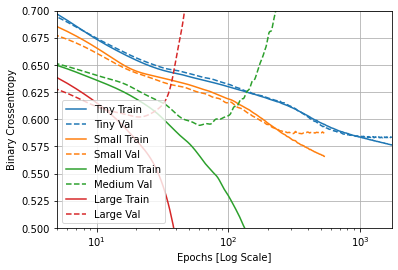

In [41]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [42]:
logdir

PosixPath('/tmp/tmpu8h3ar3m/tensorboard_logs')

In [44]:
%load_ext tensorboard

In [45]:
%tensorboard --logdir {logdir}/sizes

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [52]:
logdir

PosixPath('/tmp/tmpu8h3ar3m/tensorboard_logs')

In [53]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpu8h3ar3m/tensorboard_logs/regularizers/Tiny')

In [54]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [55]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5065,  binary_crossentropy:0.7552,  loss:2.2604,  val_accuracy:0.4730,  val_binary_crossentr

(0.5, 0.7)

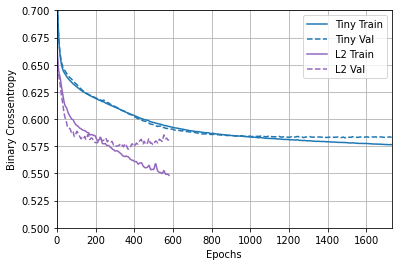

In [56]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [57]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

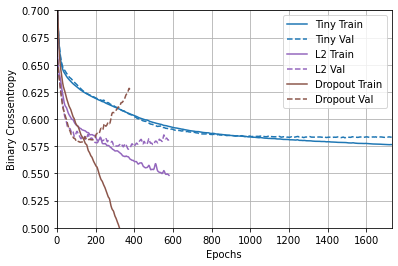

In [58]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [59]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

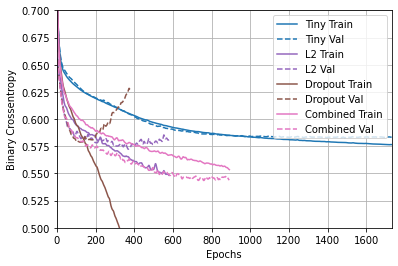

In [60]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [61]:
logdir

PosixPath('/tmp/tmpu8h3ar3m/tensorboard_logs')